Assignment 1 in DD2424 Deep learning in Data Science

Start by doing the required imports, update as we go

In [76]:
from functions import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.io as sio

In [77]:
def softmax(x):
    """Standard definition of the softmax function."""
    exp_x = np.exp(x)
    return exp_x / exp_x.sum(axis=0)

def load_batch(filename):
    """Load data from a file in the dataset directory."""
    with open('../datasets/' + filename, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

def compute_grads_num(X, Y, W, b, lamda, h, slow=False):
    """Compute numerical gradients using finite difference method."""
    num_outputs, num_inputs = W.shape
    grad_W = np.zeros(W.shape)
    grad_b = np.zeros((num_outputs, 1))

    base_cost = compute_cost(X, Y, W, b, lamda)

    for i in range(num_outputs):
        b_try = np.array(b)
        b_try[i] += h if slow else -h
        cost1 = compute_cost(X, Y, W, b_try, lamda)

        b_try = np.array(b)
        b_try[i] += h
        cost2 = compute_cost(X, Y, W, b_try, lamda)

        grad_b[i] = (cost2 - cost1) / (2 * h) if slow else (cost2 - base_cost) / h

        for j in range(num_inputs):
            W_try = np.array(W)
            W_try[i, j] += h if slow else -h
            cost1 = compute_cost(X, Y, W_try, b, lamda)

            W_try = np.array(W)
            W_try[i, j] += h
            cost2 = compute_cost(X, Y, W_try, b, lamda)

            grad_W[i, j] = (cost2 - cost1) / (2 * h) if slow else (cost2 - base_cost) / h

    return grad_W, grad_b

def display_montage(W):
    """Display the image for each label in W."""
    fig, ax = plt.subplots(2, 5)
    for i in range(2):
        for j in range(5):
            im = W[i * 5 + j, :].reshape(32, 32, 3, order='F')
            sim = (im - np.min(im)) / (np.max(im) - np.min(im))
            sim = sim.transpose(1, 0, 2)
            ax[i][j].imshow(sim, interpolation='nearest')
            ax[i][j].set_title(f"y={5 * i + j}")
            ax[i][j].axis('off')
    plt.show()

def save_as_mat(data, name="model"):
    """Save data as a .mat file for use in MATLAB."""
    sio.savemat(f'{name}.mat', {name: data})


assignment 1.1:

Write a function that reads in the data from a CIFAR-10 batch file
and returns the image and label data in separate files

In [78]:
def load(filename):
    with open('../datasets/' + filename, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')

    X = data[b'data'].astype(np.float32).reshape(-1, 3072).T / 255
    y = np.array(data[b'labels']).astype(np.int32)

    Y = np.eye(10, dtype=np.float32)[y].T

    return X, Y, y + 1


initialize train, val, and test

In [79]:
train_X, train_Y, train_y = load('cifar-10-batches-py/data_batch_1')
val_X, val_Y, val_y = load('cifar-10-batches-py/data_batch_2')
test_X, test_Y, test_y = load('cifar-10-batches-py/test_batch')

assignment 1.2:
Compute the mean and standard deviation vector for the
training data and then normalize the training, validation and test data
w.r.t. these mean and standard deviation vectors

In [80]:
def normalize_data(train_X, X):
    mean_X = np.mean(train_X, axis=1, keepdims=True)
    std_X = np.std(train_X, axis=1, keepdims=True)

    normalized_X = (X - mean_X) / std_X

    return normalized_X


normalize the train, val and test

In [81]:
train_X_norm = normalize_data(train_X, train_X)
val_X_norm = normalize_data(train_X, val_X)
test_X_norm = normalize_data(train_X, test_X)


assignment 1.3:

after reading in and pre-processing the data, you can initialize the parameters of the model W and b as you now know what size they should be. W has size [K, d] and b has size [K, 1]. Initialize each entry to have Gaussian random values with mean 0 and standard deviation 0.01. 

In [82]:
def initialize_parameters(K, d):
    W = np.random.randn(K, d) * 0.01
    b = np.random.randn(K, 1) * 0.01
    return W, b

K = 10
d = train_X_norm.shape[0]
W, b = initialize_parameters(K, d)


Assignment 1.4:

Check the function runs on a subset of the training data given a random initialization of the parameters 

In [83]:
def evaluate_classifier(X, W, b):
    s = np.dot(W, X) + b
    P = softmax(s)
    return P


Assignment 1.5:

write the function that computes the cost function for a set of images

In [84]:
def compute_cost(X, Y, W, b, lambda_):
    P = evaluate_classifier(X, W, b)
    cross_entropy_loss = -np.mean(np.sum(Y * np.log(P), axis=0))
    regularization_term = lambda_ * np.sum(W ** 2)
    J = cross_entropy_loss + regularization_term
    return J

# Example usage:
compute_cost(train_X_norm, train_Y, W, b, 0.1)


2.794138654464774

assignment 1.6:

a function that calculates the accuracy of the classifier given the input data X, labels y, weight matrix W, and bias vector b

In [85]:
def compute_accuracy(X, y, W, b):
    P = evaluate_classifier(X, W, b)
    predictions = np.argmax(P, axis=0)
    correct_predictions = np.sum(predictions == (y - 1))
    acc = correct_predictions / y.shape[0]
    return acc

# Example usage:
accuracy = compute_accuracy(train_X_norm, train_y, W, b)
print("Accuracy: {:.2%}".format(accuracy))


Accuracy: 9.15%


1.7:

compute gradient, the analytical gradient and the numerical gradient.

compute the relative error.

In [86]:
def compute_gradients(X, Y, P, W, lambda_):
    n = X.shape[1]
    g = P - Y
    grad_W = (1/n) * np.dot(g, X.T) + 2 * lambda_ * W
    grad_b = (1/n) * np.sum(g, axis=1).reshape(-1, 1)
    return grad_W, grad_b

# Select a small portion of the data
X_small = train_X_norm[:20, :1]
Y_small = train_Y[:, :1]
W_small = W[:, :20]
b_small = b
lambda_ = 0

# Compute the analytical gradients
P_small = evaluate_classifier(X_small, W_small, b_small)
grad_W_analytical, grad_b_analytical = compute_gradients(X_small, Y_small, P_small, W_small, lambda_)

# Compute the numerical gradients
grad_W_numerical, grad_b_numerical = compute_grads_num(X_small, Y_small, W_small, b_small, lambda_, 1e-6)

# Compute the relative error
eps = 1e-10
relative_error_W = np.abs(grad_W_analytical - grad_W_numerical) / np.maximum(eps, np.abs(grad_W_analytical) + np.abs(grad_W_numerical))
relative_error_b = np.abs(grad_b_analytical - grad_b_numerical) / np.maximum(eps, np.abs(grad_b_analytical) + np.abs(grad_b_numerical))

print("Relative error W:", np.max(relative_error_W))
print("Relative error b:", np.max(relative_error_b))


Relative error W: 1.6053861232877575e-06
Relative error b: 2.249169625318029e-07


Assignment 1.8:



In [87]:
def mini_batch_gd_with_validation(X_train, Y_train, X_val, Y_val, GDparams, W, b, lambda_):
    n_batch, eta, n_epochs = GDparams
    n = X_train.shape[1]
    train_loss = []
    val_loss = []
    
    for epoch in range(n_epochs):
        for j in range(n // n_batch):
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            inds = slice(j_start, j_end)
            X_batch = X_train[:, inds]
            Y_batch = Y_train[:, inds]

            P_batch = evaluate_classifier(X_batch, W, b)
            grad_W, grad_b = compute_gradients(X_batch, Y_batch, P_batch, W, lambda_)

            W -= eta * grad_W
            b -= eta * grad_b
        
        # Compute and store the cost after each epoch for training and validation data
        train_loss.append(compute_cost(X_train, Y_train, W, b, lambda_))
        val_loss.append(compute_cost(X_val, Y_val, W, b, lambda_))

    return W, b, train_loss, val_loss


n_batch = 100
eta = 0.001
n_epochs = 40
lambda_ = 0

GDparams = (n_batch, eta, n_epochs)

W_star, b_star, train_loss, val_loss = mini_batch_gd_with_validation(train_X_norm, train_Y, val_X_norm, val_Y, GDparams, W, b, lambda_=0)

#val_w, val_b, val_loss = mini_batch_gd(val_X_norm, val_Y, GDparams, W, b, lambda_)




In [88]:
test_accuracy = compute_accuracy(test_X_norm, test_y, W_star, b_star)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Test accuracy: 38.77%


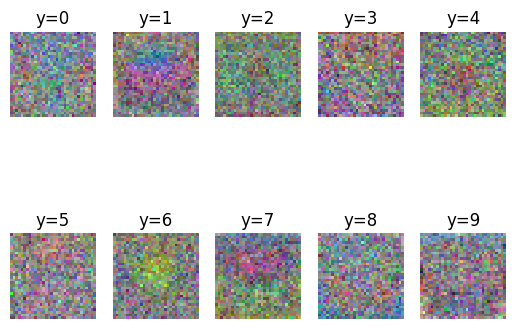

In [94]:
montage(W_star)

plots the cost function and the accuracy of the model on the training and validation set as a function of the number of epochs.

In [95]:
def plot_train_val_cost(train_loss, val_loss, lambda_=0):
    plt.figure()
    plt.plot(range(1, len(train_loss) + 1), train_loss, label=f'Training Loss (Lambda = {lambda_})')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label=f'Validation Loss (Lambda = {lambda_})')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('Cost vs Epoch')
    plt.legend()
    plt.show()



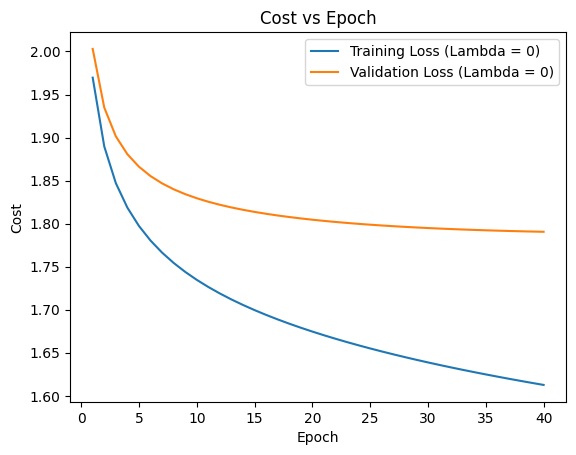

In [96]:
plot_train_val_cost(train_loss, val_loss, lambda_=0)


Parameter variation

Training with parameters: {'lambda_': 0, 'n_epochs': 40, 'n_batch': 100, 'eta': 0.1}


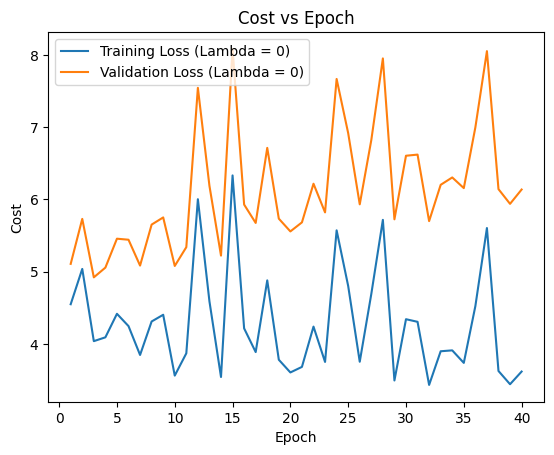

Test accuracy: 28.99%



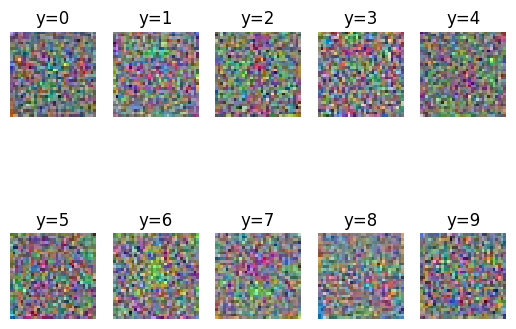

Training with parameters: {'lambda_': 0, 'n_epochs': 40, 'n_batch': 100, 'eta': 0.001}


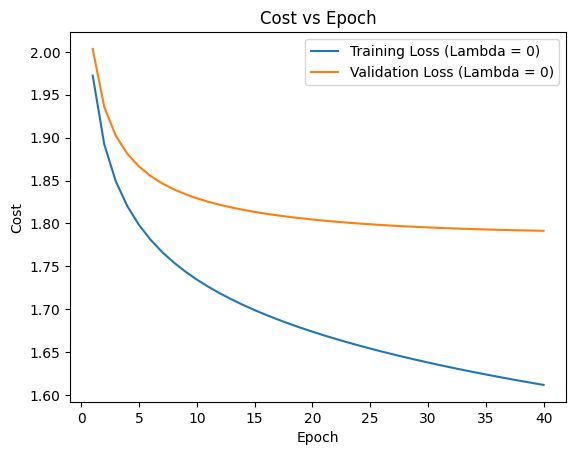

Test accuracy: 38.85%



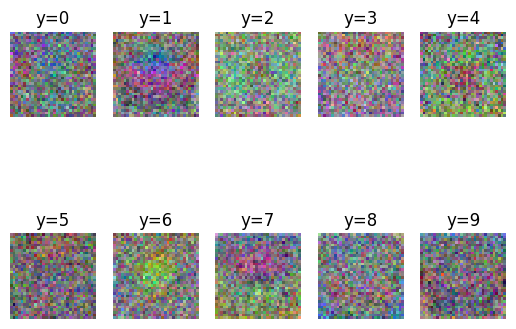

Training with parameters: {'lambda_': 0.1, 'n_epochs': 40, 'n_batch': 100, 'eta': 0.001}


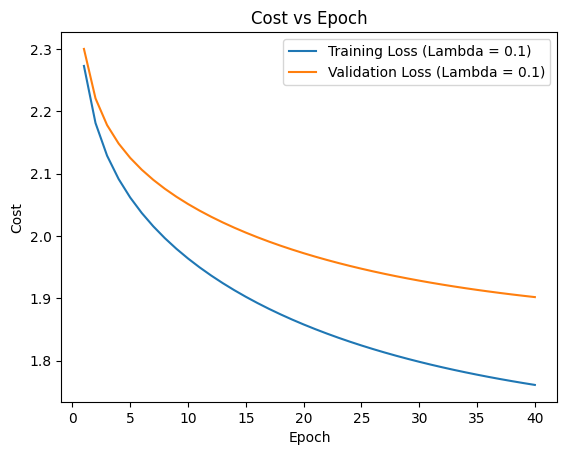

Test accuracy: 39.23%



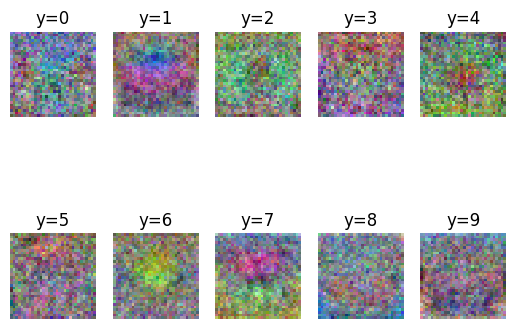

Training with parameters: {'lambda_': 1, 'n_epochs': 40, 'n_batch': 100, 'eta': 0.001}


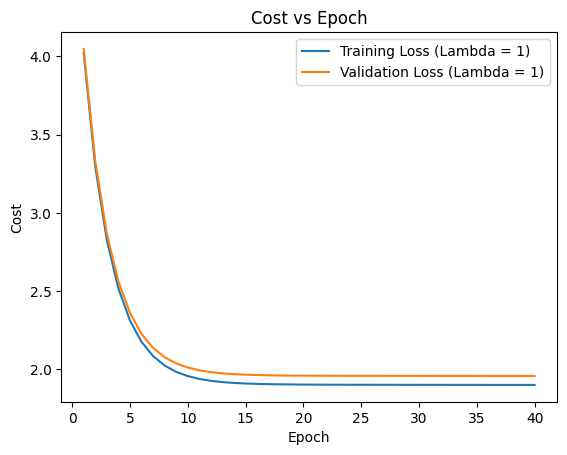

Test accuracy: 37.52%



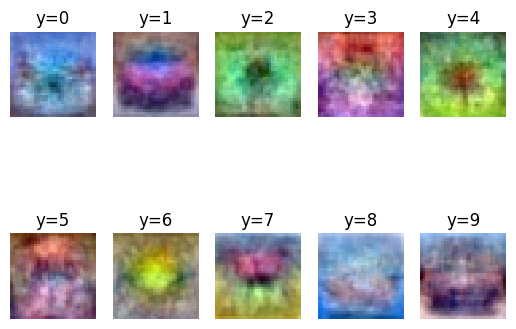

In [97]:
parameter_settings = [
    {"lambda_": 0, "n_epochs": 40, "n_batch": 100, "eta": 0.1},
    {"lambda_": 0, "n_epochs": 40, "n_batch": 100, "eta": 0.001},
    {"lambda_": 0.1, "n_epochs": 40, "n_batch": 100, "eta": 0.001},
    {"lambda_": 1, "n_epochs": 40, "n_batch": 100, "eta": 0.001},
]

for params in parameter_settings:
    print(f"Training with parameters: {params}")
    W, b = initialize_parameters(K, d)
    GDparams = (params["n_batch"], params["eta"], params["n_epochs"])

    W_star, b_star, train_loss, val_loss = mini_batch_gd_with_validation(train_X_norm, train_Y, val_X_norm, val_Y, GDparams, W, b, lambda_=params["lambda_"])
    plot_train_val_cost(train_loss, val_loss, lambda_=params["lambda_"])
    
    
    test_accuracy = compute_accuracy(test_X_norm, test_y, W_star, b_star)
    print(f"Test accuracy: {test_accuracy * 100:.2f}%\n")
    montage(W_star)


As for the effect of increasing the amount of regularization and the importance of the correct learning rate:

Increasing regularization (lambda): When you increase the regularization term, the model becomes less likely to overfit the training data. Regularization adds a penalty to the cost function, which discourages large weights. This results in a simpler model that is less likely to overfit the training data, which could improve generalization to the validation and test data. However, if the regularization term is too large, the model might become too simple and underfit the data, resulting in lower accuracy.

Learning rate (eta): The learning rate determines the step size during the gradient descent optimization. If the learning rate is too large, the optimization might overshoot the optimal solution and fail to converge, leading to unstable training and high cost values. If the learning rate is too small, the optimization will take longer to converge, which might require more training epochs. It is crucial to find a suitable learning rate that allows the model to converge to a good solution in a reasonable amount of time.

In [ ]:
import os
import matplotlib.pyplot as plt

def save_loss_and_weights(train_loss, val_loss, W_star, title, lambda_, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save training and validation loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss (lambda={lambda_}) - {title}")
    plt.legend()
    plt.savefig(f"{output_folder}/loss_lambda_{lambda_}_eta_{title}.png")
    plt.close()

    # Save weight templates
    templates = []
    for i in range(10):
        im = W_star[i].reshape(32, 32, 3)
        im = (im - im.min()) / (im.max() - im.min())
        templates.append(im)

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    fig.suptitle(f"Weight Templates (lambda={lambda_}) - {title}")
    for i, ax in enumerate(axes.flat):
        ax.imshow(templates[i])
        ax.axis('off')
    plt.savefig(f"{output_folder}/weights_lambda_{lambda_}_eta_{title}.png")
    plt.close()

output_folder = "results"

for params in parameter_settings:
    print(f"Training with parameters: {params}")
    W, b = initialize_parameters(K, d)
    GDparams = (params["n_batch"], params["eta"], params["n_epochs"])

    W_star, b_star, train_loss, val_loss = mini_batch_gd_with_validation(train_X_norm, train_Y, val_X_norm, val_Y, GDparams, W, b, lambda_=params["lambda_"])

    test_accuracy = compute_accuracy(test_X_norm, test_y, W_star, b_star)
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")

    title = f"eta={params['eta']}, n_epochs={params['n_epochs']}, n_batch={params['n_batch']}"
    save_loss_and_weights(train_loss, val_loss, W_star, title, params["lambda_"], output_folder)
    print("\n")
